In [17]:
from query_utils import SnowflakeEngine
import pandas as pd
import seaborn as sns
engine = SnowflakeEngine()
engine.connect()

In [18]:
query = """

WITH dates AS (
  SELECT
    date_started_at
  FROM
    ds_prod.model.dim_date
  WHERE
    date_started_at >= '2014-01-01'
    AND is_date_completed
),
base_table AS (
  SELECT
    d.date_started_at,
    experiment_group
  FROM
    dates AS d
    CROSS JOIN (
      VALUES
        ('control'),
        ('experiment')
    ) AS t(experiment_group)
),
cohorts AS (
  SELECT
    date_trunc('day', signed_up_at) AS signup_date,
    CASE
      WHEN is_in_crm_global_holdout THEN 'control'
      ELSE 'experiment'
    END AS experiment_group,
    count(1) users
  FROM
    ds_prod.model.dim_user
  WHERE
    is_in_crm_global_holdout IS NOT NULL
    AND NOT is_internal_user
  GROUP BY
    1,
    2
),
trials AS (
  SELECT
    trial_started_at,
    provider,
    brand_owning_user_id AS user_id
  FROM
    ds_prod.model.dim_subscription
  WHERE
    trial_started_at > '2019-01-01'
    AND plan_name = 'Canva Pro'
),
trialling_users AS (
  SELECT
    date_trunc('day', trial_started_at) AS trial_start_date,
    CASE
      WHEN is_in_crm_global_holdout THEN 'control'
      ELSE 'experiment'
    END AS experiment_group,
    count(
      CASE
        WHEN t.provider = 'internal' THEN 1
      END
    ) web_trialling_users,
    count(
      CASE
        WHEN t.provider = 'google' THEN 1
      END
    ) android_trialling_users,
    count(
      CASE
        WHEN t.provider = 'apple' THEN 1
      END
    ) ios_trialling_users,
    count(1) trialling_users
  FROM
    ds_prod.model.dim_user AS u
    JOIN trials AS t ON u.user_id = t.user_id
  WHERE
    u.is_in_crm_global_holdout IS NOT NULL
    AND NOT u.is_internal_user
  GROUP BY
    1,
    2
),
results AS (
  SELECT
    bt.date_started_at,
    bt.experiment_group,

    sum(coalesce(t.web_trialling_users, 0)) over (
      PARTITION by bt.experiment_group
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 27 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) web_trial_rate_28d,
    sum(coalesce(t.web_trialling_users, 0)) over (
      PARTITION by bt.experiment_group
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 6 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) web_trial_rate_7d,

    sum(coalesce(t.android_trialling_users, 0)) over (
      PARTITION by bt.experiment_group
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 27 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) android_trial_rate_28d,
    sum(coalesce(t.android_trialling_users, 0)) over (
      PARTITION by bt.experiment_group
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 6 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) android_trial_rate_7d,

    sum(coalesce(t.ios_trialling_users, 0)) over (
      PARTITION by bt.experiment_group
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 27 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) ios_trial_rate_28d,
    sum(coalesce(t.ios_trialling_users, 0)) over (
      PARTITION by bt.experiment_group
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 6 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) ios_trial_rate_7d,

    sum(coalesce(t.trialling_users, 0)) over (
      PARTITION by bt.experiment_group
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 27 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) trial_rate_28d,
    sum(coalesce(t.trialling_users, 0)) over (
      PARTITION by bt.experiment_group
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN 6 preceding
        AND current ROW
    ) / nullif(
      sum(coalesce(c.users, 0)) over (
        PARTITION by bt.experiment_group
        ORDER BY
          bt.date_started_at ASC ROWS BETWEEN unbounded preceding
          AND current ROW
      ),
      0
    ) trial_rate_7d,
    sum(coalesce(c.users, 0)) over (
      PARTITION by bt.experiment_group
      ORDER BY
        bt.date_started_at ASC ROWS BETWEEN unbounded preceding
        AND current ROW
    ) group_size
  FROM
    base_table bt
    LEFT JOIN cohorts c ON bt.date_started_at = c.signup_date
    AND bt.experiment_group = c.experiment_group
    LEFT JOIN trialling_users t ON bt.date_started_at = t.trial_start_date
    AND bt.experiment_group = t.experiment_group
)
SELECT
  date_started_at AS "Date",
  DENSE_RANK() OVER (
    ORDER BY
      date_started_at DESC
  ) AS "day_rank",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Experiment Group Size",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN trial_rate_28d
    END
  ) "Control Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN trial_rate_28d
    END
  ) "Experiment Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN web_trial_rate_28d
    END
  ) "Control Web Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN web_trial_rate_28d
    END
  ) "Experiment Web Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN android_trial_rate_28d
    END
  ) "Control Android Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN android_trial_rate_28d
    END
  ) "Experiment Android Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN ios_trial_rate_28d
    END
  ) "Control iOS Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN ios_trial_rate_28d
    END
  ) "Experiment iOS Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN trial_rate_7d
    END
  ) "Control Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN trial_rate_7d
    END
  ) "Experiment Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN web_trial_rate_7d
    END
  ) "Control Web Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN web_trial_rate_7d
    END
  ) "Experiment Web Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN android_trial_rate_7d
    END
  ) "Control Android Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN android_trial_rate_7d
    END
  ) "Experiment Android Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'control' THEN ios_trial_rate_7d
    END
  ) "Control iOS Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN ios_trial_rate_7d
    END
  ) "Experiment iOS Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN trial_rate_28d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN trial_rate_28d
      END
    ),
    0
  ) - 1 "Relative Uplift Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN web_trial_rate_28d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN web_trial_rate_28d
      END
    ),
    0
  ) - 1 "Relative Uplift Web Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN android_trial_rate_28d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN android_trial_rate_28d
      END
    ),
    0
  ) - 1 "Relative Uplift Android Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN ios_trial_rate_28d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN ios_trial_rate_28d
      END
    ),
    0
  ) - 1 "Relative Uplift iOS Trial Rate - 28d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN trial_rate_7d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN trial_rate_7d
      END
    ),
    0
  ) - 1 "Relative Uplift Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN web_trial_rate_7d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN web_trial_rate_7d
      END
    ),
    0
  ) - 1 "Relative Uplift Web Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN android_trial_rate_7d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN android_trial_rate_7d
      END
    ),
    0
  ) - 1 "Relative Uplift Android Trial Rate - 7d",
  MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN ios_trial_rate_7d
    END
  ) / nullif(
    MAX(
      CASE
        WHEN experiment_group = 'control' THEN ios_trial_rate_7d
      END
    ),
    0
  ) - 1 "Relative Uplift iOS Trial Rate - 7d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN trial_rate_28d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN trial_rate_28d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Trials - 28d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN web_trial_rate_28d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN web_trial_rate_28d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Web Trials - 28d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN android_trial_rate_28d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN android_trial_rate_28d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Android Trials - 28d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN ios_trial_rate_28d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN ios_trial_rate_28d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift iOS Trials - 28d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN trial_rate_7d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN trial_rate_7d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Trials - 7d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN web_trial_rate_7d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN web_trial_rate_7d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Web Trials - 7d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN android_trial_rate_7d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN android_trial_rate_7d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift Android Trials - 7d",
  (
    MAX(
      CASE
        WHEN experiment_group = 'experiment' THEN ios_trial_rate_7d
      END
    ) - MAX(
      CASE
        WHEN experiment_group = 'control' THEN ios_trial_rate_7d
      END
    )
  ) * MAX(
    CASE
      WHEN experiment_group = 'experiment' THEN group_size
    END
  ) "Uplift iOS Trials - 7d",
  0 AS "zero_line"
FROM
  results r
WHERE
  r.date_started_at >= '2019-01-01'
GROUP BY
  1
ORDER BY
  1 DESC

"""
df = engine.run_query(query)

In [19]:
df.head()

,date,day_rank,experiment group size,control trial rate - 28d,experiment trial rate - 28d,control web trial rate - 28d,experiment web trial rate - 28d,control android trial rate - 28d,experiment android trial rate - 28d,control ios trial rate - 28d,...,relative uplift ios trial rate - 7d,uplift trials - 28d,uplift web trials - 28d,uplift android trials - 28d,uplift ios trials - 28d,uplift trials - 7d,uplift web trials - 7d,uplift android trials - 7d,uplift ios trials - 7d,zero_line
0,2021-05-15,1,313519152,0.002594,0.002652,0.001968,0.001978,0.000307,0.000333,0.000320,...,0.074626865672,18184.110816,3135.191520,8151.497952,6583.902192,6583.902192,1567.595760,3448.710672,1567.595760,0
1,2021-05-14,2,313193434,0.002606,0.002664,0.001973,0.001984,0.000309,0.000336,0.000325,...,0.088235294118,18165.219172,3445.127774,8456.222718,5950.675246,5950.675246,939.580302,3445.127774,1879.160604,0
2,2021-05-13,3,312758776,0.002622,0.002678,0.001982,0.001992,0.000313,0.000339,0.000327,...,0.102941176471,17514.491456,3127.587760,8131.728176,6567.934296,5942.416744,312.758776,3753.105312,2189.311432,0
3,2021-05-12,4,312232727,0.002632,0.002690,0.001991,0.002002,0.000313,0.000336,0.000329,...,0.084507042254,18109.498166,3434.559997,7181.352721,6869.119994,4371.258178,-936.698181,3434.559997,1873.396362,0
4,2021-05-11,5,311680029,0.002643,0.002696,0.002000,0.002012,0.000307,0.000329,0.000336,...,0.067567567568,16519.041537,3740.160348,6856.960638,5921.920551,4986.880464,1246.720116,2805.120261,1558.400145,0


In [20]:
df['date'] = pd.to_datetime(df['date'])

In [21]:
df.set_index('date',inplace=True)
df.sort_index(inplace=True)

In [22]:
df.head()

,day_rank,experiment group size,control trial rate - 28d,experiment trial rate - 28d,control web trial rate - 28d,experiment web trial rate - 28d,control android trial rate - 28d,experiment android trial rate - 28d,control ios trial rate - 28d,experiment ios trial rate - 28d,...,relative uplift ios trial rate - 7d,uplift trials - 28d,uplift web trials - 28d,uplift android trials - 28d,uplift ios trials - 28d,uplift trials - 7d,uplift web trials - 7d,uplift android trials - 7d,uplift ios trials - 7d,zero_line
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,866,70692339,0.000025,0.000028,0.000025,0.000028,0.000000,0.000000,0.000000,0.000000,...,None,212.077017,212.077017,0.000000,0.000000,212.077017,212.077017,0.000000,0.000000,0
2019-01-02,865,70852590,0.000075,0.000073,0.000075,0.000073,0.000000,0.000000,0.000000,0.000000,...,None,-141.705180,-141.705180,0.000000,0.000000,-141.705180,-141.705180,0.000000,0.000000,0
2019-01-03,864,71021090,0.000127,0.000123,0.000127,0.000123,0.000000,0.000000,0.000000,0.000000,...,None,-284.084360,-284.084360,0.000000,0.000000,-284.084360,-284.084360,0.000000,0.000000,0
2019-01-04,863,71183470,0.000172,0.000171,0.000172,0.000171,0.000000,0.000000,0.000000,0.000000,...,None,-71.183470,-71.183470,0.000000,0.000000,-71.183470,-71.183470,0.000000,0.000000,0
2019-01-05,862,71317852,0.000210,0.000206,0.000210,0.000206,0.000000,0.000000,0.000000,0.000000,...,None,-285.271408,-285.271408,0.000000,0.000000,-285.271408,-285.271408,0.000000,0.000000,0


In [23]:
df.columns

Index(['day_rank', 'experiment group size', 'control trial rate - 28d',
       'experiment trial rate - 28d', 'control web trial rate - 28d',
       'experiment web trial rate - 28d', 'control android trial rate - 28d',
       'experiment android trial rate - 28d', 'control ios trial rate - 28d',
       'experiment ios trial rate - 28d', 'control trial rate - 7d',
       'experiment trial rate - 7d', 'control web trial rate - 7d',
       'experiment web trial rate - 7d', 'control android trial rate - 7d',
       'experiment android trial rate - 7d', 'control ios trial rate - 7d',
       'experiment ios trial rate - 7d', 'relative uplift trial rate - 28d',
       'relative uplift web trial rate - 28d',
       'relative uplift android trial rate - 28d',
       'relative uplift ios trial rate - 28d',
       'relative uplift trial rate - 7d',
       'relative uplift web trial rate - 7d',
       'relative uplift android trial rate - 7d',
       'relative uplift ios trial rate - 7d', 'uplift

In [24]:
df_web_relative = df[['relative uplift web trial rate - 28d']]

In [25]:
df_web_relative.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2019-01-01 to 2021-05-15
Data columns (total 1 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   relative uplift web trial rate - 28d  866 non-null    object
dtypes: object(1)
memory usage: 13.5+ KB


In [26]:
df_web_relative['Year'] = df_web_relative.index.year

<ipython-input-26-d41189fd5ce4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web_relative['Year'] = df_web_relative.index.year


In [27]:
df_web_relative['day_of_year'] = df_web_relative.index.dayofyear

<ipython-input-27-b997f76cb06c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web_relative['day_of_year'] = df_web_relative.index.dayofyear


In [28]:
df_web_relative.head()

,relative uplift web trial rate - 28d,Year,day_of_year
date,,,
2019-01-01,0.120000000000,2019,1
2019-01-02,-0.026666666667,2019,2
2019-01-03,-0.031496062992,2019,3
2019-01-04,-0.005813953488,2019,4
2019-01-05,-0.019047619048,2019,5


In [29]:
df_web_relative['relative uplift web trial rate - 28d'] = df_web_relative['relative uplift web trial rate - 28d'].astype(float)

<ipython-input-29-93e2ae0dbc15>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_web_relative['relative uplift web trial rate - 28d'] = df_web_relative['relative uplift web trial rate - 28d'].astype(float)


In [32]:
df_web_relative_pivot = pd.pivot(df_web_relative,index = 'day_of_year', columns = 'Year', values = 'relative uplift web trial rate - 28d')

In [37]:
df_web_relative_pivot = df_web_relative_pivot.astype(float)
df_web_relative_pivot['Zero Line'] = 0

<AxesSubplot:title={'center':'Relative Web Trial Rate Uplift by Calendar Year'}, xlabel='Day Of Year', ylabel='Relative Web Trial Rate Uplift'>

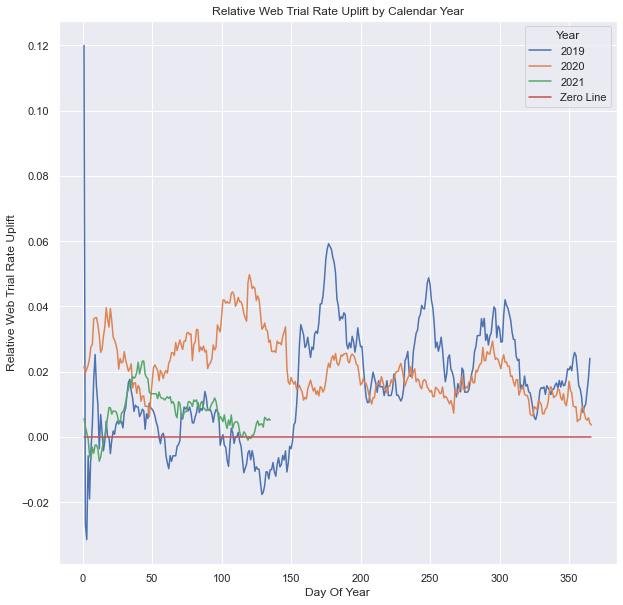

In [38]:
sns.set()
df_web_relative_pivot.plot(figsize=(10,10),title="Relative Web Trial Rate Uplift by Calendar Year",ylabel = "Relative Web Trial Rate Uplift",xlabel="Day Of Year")

In [ ]:
df_web_raw = df[['control web trial rate - 28d',
       'experiment web trial rate - 28d']]

In [ ]:
df_web_raw.head()

In [ ]:
df_web_raw['Year'] = df_web_raw.index.year

In [ ]:
df_web_raw['day_of_year'] = df_web_raw.index.dayofyear

In [ ]:
df_web_raw.head()

In [ ]:
df_web_raw_pivot = pd.pivot(df_web_raw, index = 'day_of_year', columns = 'Year', values = ['control web trial rate - 28d','experiment web trial rate - 28d'])

In [ ]:
df_web_raw_pivot.head()

In [ ]:
df_web_raw_pivot = df_web_raw_pivot.astype(float)

In [ ]:
df_web_raw_pivot.plot(figsize=(10,10),title="Raw Web Trial Rate - Global Holdout vs Experiment",ylabel = "Web Trial Rate",xlabel="Day Of Year")